<a href="https://colab.research.google.com/github/Radhibomma/GCollab/blob/main/cgan_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤪 Conditional WGAN-GP on CelebA Faces - Train

In this notebook, we'll walk through the steps required to train your own Conditional GAN on the CelebA faces dataset

The code has been adapted from the excellent [CGAN tutorial](https://keras.io/examples/generative/conditional_gan/) created by Sayak Paul, available on the Keras website.

In [3]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import kagglehub

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

## 0. Parameters <a name="parameters"></a>

In [4]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

## 1. Prepare the data <a name="prepare"></a>

In [5]:
# Load the label dataset
attributes = pd.read_csv("https://raw.githubusercontent.com/awaisjafar/Gender-Detection-Resnet-18/refs/heads/master/datasets/celebsA/list_attr_celeba.csv")
print(attributes.columns)

x_train = attributes["image_id"][6:50000]
x_test = attributes["image_id"][:5]
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
# Load the data
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [7]:
path = kagglehub.dataset_download("nikhilbartwal001/celeba")

train_data = utils.image_dataset_from_directory(
    # "https://storage.googleapis.com/kagglesdsdata/datasets/698917//t/celebA/000001.png?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=gcp-kaggle-com%40kaggle-161607.iam..com%2F20241105%%2Fstorage%2Fgoog4_request&X-Goog-Date=&X--=&X-Goog-=&Xb3",
    path,
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

100%|██████████| 1.32G/1.32G [00:22<00:00, 63.3MB/s]

Extracting files...


Found 202599 files belonging to 2 classes.


In [8]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [9]:
def showimages(images, figsize, grid_size):
    fig = plt.figure(figsize=(figsize, figsize))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(5):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.axis("off")
        ax.imshow(images[i, :, :], cmap="Greys")

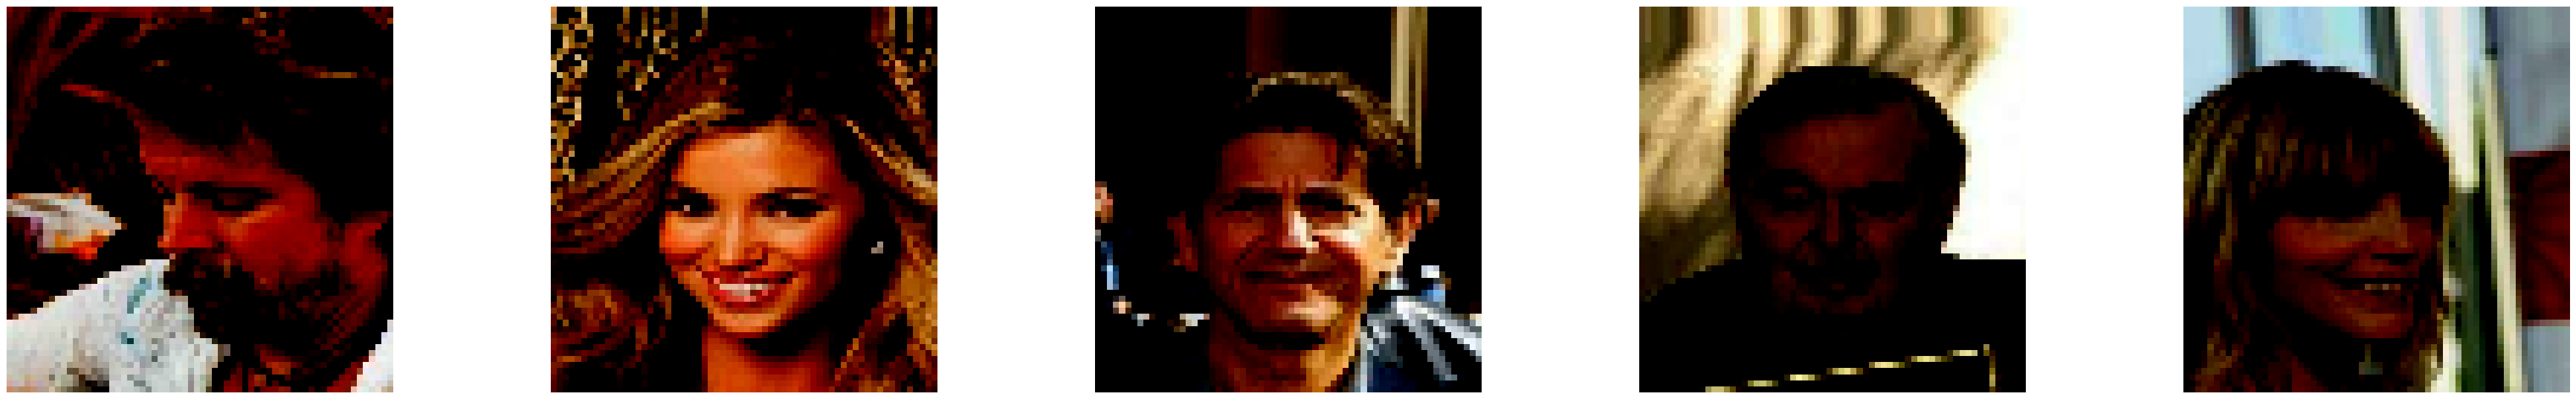

In [10]:
images, paths = next(iter(train.take(1)))

showimages(images, 50, 5)

# Show some faces from the training set
#train_sample = sample_batch(train)

In [11]:
#display(train_sample, cmap=None)

## 2. Build the GAN <a name="build"></a>

In [12]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 64, 64, 2)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 5)      │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          5,184 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32, 32, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 128)    │        131,200 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 128)    │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │        262,272 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 8, 8, 128)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 128)      │              0 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 128)      │        262,272 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 4, 4, 128)      │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 4, 4, 128)      │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 1, 1, 1)        │          2,049 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1)              │              0 │ conv2d_4[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 34)             │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 34)       │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 4, 4, 128)      │         69,632 │ reshape[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 4, 4, 128)      │            512 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 4, 4, 128)      │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 8, 8, 128)      │        262,144 │ leaky_re_lu_4[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 128)      │            512 │ conv2d_transpose_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 8, 8, 128)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 16, 16, 128)    │        262,144 │ leaky_re_lu_5[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_transpose_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 32, 32, 64)     │        131,072 │ leaky_re_lu_6[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 729,859 (2.78 MB)

 Trainable params: 728,963 (2.78 MB)

 Non-trainable params: 896 (3.50 KB)

In [14]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [15]:
# Create a GAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [16]:
if LOAD_MODEL:
    cgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [17]:
# Compile the GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [18]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.ckpt.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        # 0 label
        zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
        zero_label = tf.convert_to_tensor( zero_label, dtype=None, dtype_hint=None, name=None)
        #print(zero_label)
        #print(random_latent_vectors)
        generated_images = self.model.generator(
            [random_latent_vectors, zero_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        #display(
            #generated_images
            #save_to="./generated_img_%03d_label_0.png" % (epoch),
            #cmap=None,
        #)

        # showimages(generated_images, 50, 5)



        # 1 label
        one_label = np.repeat([[0, 1]], self.num_img, axis=0)
        one_label = tf.convert_to_tensor(one_label, dtype=None, dtype_hint=None, name=None)
        generated_images = self.model.generator(
            [random_latent_vectors, one_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        #display(
            #generated_images
            #save_to="./generated_img_%03d_label_1.png" % (epoch),
            #cmap=None,
        #)

        # showimages(generated_images, 50, 5)

In [19]:
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - c_gp: 0.7438 - c_loss: 7.3545 - c_wass_loss: -0.0837 - g_loss: 0.0791
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.7351 - c_loss: 7.1510 - c_wass_loss: -0.1998 - g_loss: 0.1119   
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step - c_gp: 0.7215 - c_loss: 6.8707 - c_wass_loss: -0.3447 - g_loss: 0.1849
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - c_gp: 0.7003 - c_loss: 6.4300 - c_wass_loss: -0.5732 - g_loss: 0.3145
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step - c_gp: 0.6753 - c_loss: 5.9214 - c_wass_loss: -0.8320 - g_loss: 0.5141
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.6506 - c_loss: 5.1138 - c_wass_loss: -1.3926 - g_loss: 0.7787   
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.6228 - c_loss: 4.3681 - c_wass_loss: -1.8599 - g_loss: 1.1425
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.5919 - c_loss: 2.9728 - c_wass_loss: -2.9458 - g_loss: 1.6900
Epoch 9/2000
1/1 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - c_gp: 0.0408 - c_loss: 1.3437 - c_wass_loss: 0.9358 - g_loss: -31.6140
Epoch 1586/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.0413 - c_loss: -5.1463 - c_wass_loss: -5.5596 - g_loss: -37.4613   
Epoch 1587/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.0591 - c_loss: -8.8890 - c_wass_loss: -9.4800 - g_loss: -42.4159
Epoch 1588/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.0638 - c_loss: -11.2182 - c_wass_loss: -11.8565 - g_loss: -38.8406
Epoch 1589/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step - c_gp: 0.0518 - c_loss: -7.1203 - c_wass_loss: -7.6388 - g_loss: -41.8394
Epoch 1590/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.0557 - c_loss: -11.3169 - c_wass_loss: -11.8738 - g_loss: -36.7733   
Epoch 1591/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - c_gp: 0.0747 - c_loss: -2.5799 - c_wass_loss: -3.3266 - g_loss: -44.1743   
Epoch 1592/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - c_gp: 0.0722 - c_loss: 5.4050 - c_wass_loss: 4.6828 - g_

In [20]:
# Save the final models
generator.save("./generator.keras")
critic.save("./critic.keras")

## Generate images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


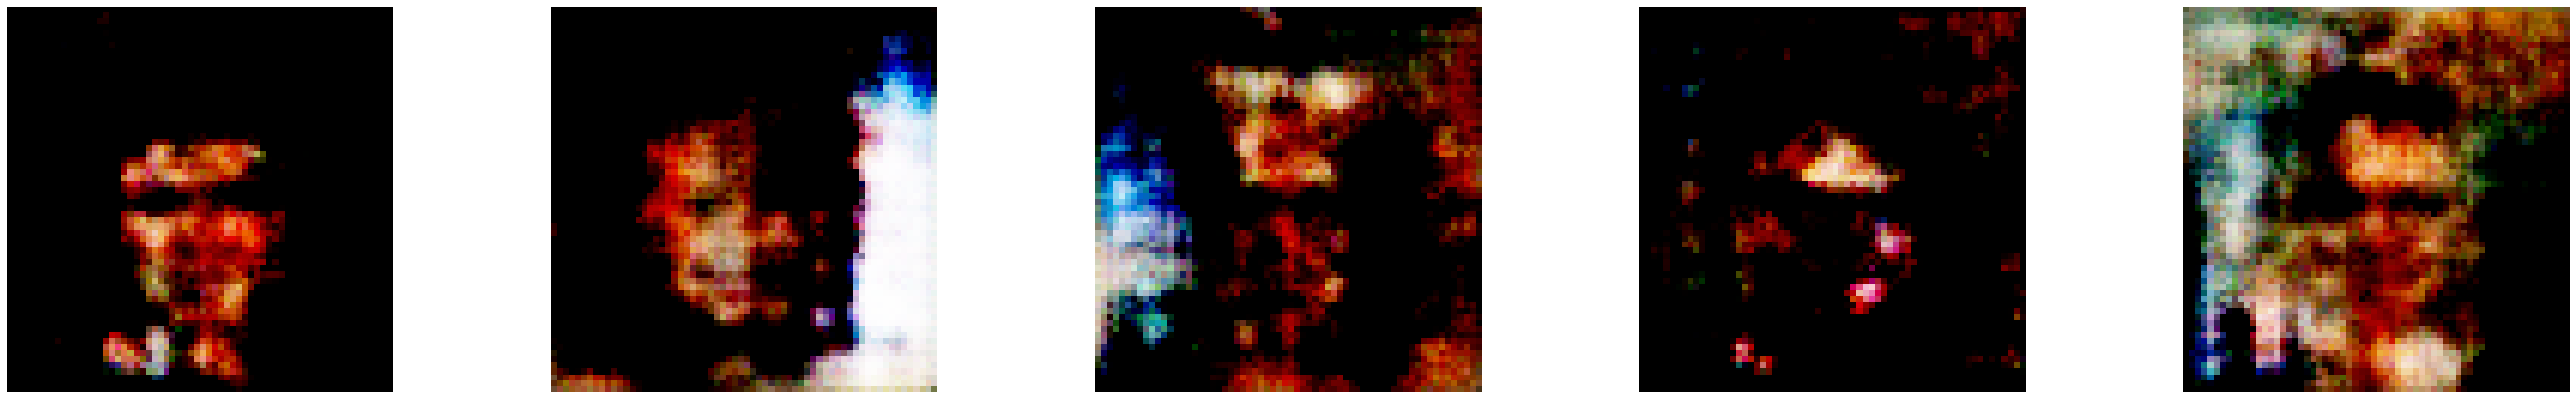

In [21]:
# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])

showimages(imgs, 50, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


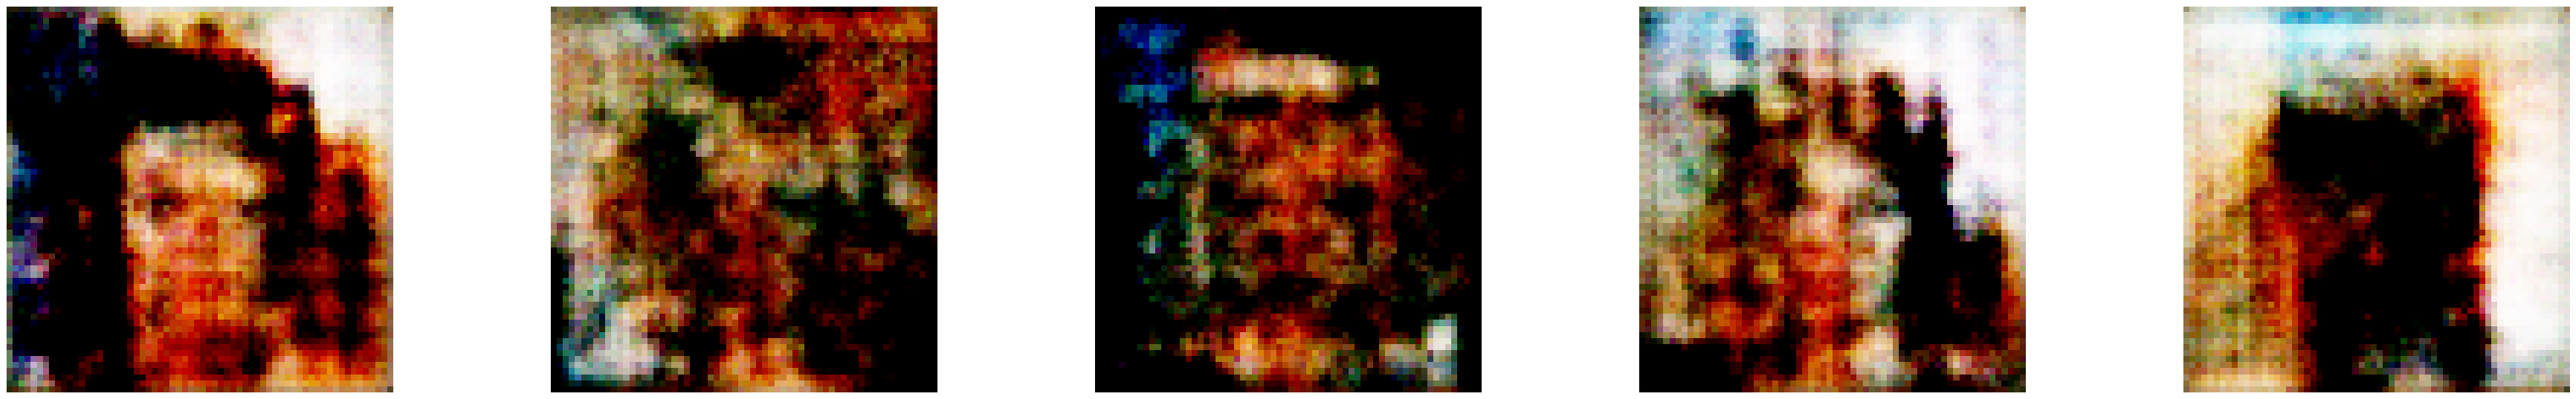

In [22]:
# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])

showimages(imgs, 50, 5)